In [1]:
from ultralytics import YOLO

import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
import torch

/storage/conda/envs/env_qc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ultralytics import SAM
from ultralytics import FastSAM

In [3]:
from dataset import PascalPartDataset
from lightning_module import PascalPartModel

In [5]:

import segmentation_models_pytorch as smp

encoder = smp.MAnet(
            # encoder_name=encoder_name,        
            # encoder_weights=encoder_weights,  
            classes=2,                     
            activation=None                   
        )


In [6]:
encoder

MAnet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [4]:
df_train_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
df_val_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})

# extract names of images and masks for train and val splts
splits = ["train_id", "val_id"]
splits_samples = {}

for split in splits:
    with open(f'/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/data/{split}.txt') as f:
        splits_samples[split] = f.read().splitlines()

path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/Pascal-part'

# create dataframes with full paths to images and masks
df_train_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['train_id']]
df_train_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['train_id']]
df_val_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['val_id']]
df_val_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['val_id']]

In [5]:
transform = A.Compose([
        A.Resize(640, 640),
        # A.Resize(256, 256),
        # A.Normalize(
        #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        #     # max_pixel_value=255.0,
        # ),
        # ToTensorV2()
    ])

In [6]:
# Create the dataset and dataloader
val_dataset = PascalPartDataset(
    df_val_paths,
    # transform=transform
)
train_dataset = PascalPartDataset(
    df_train_paths, 
    # transform=transform
)

In [7]:
from torch.utils.data import DataLoader

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=63)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=63)

# YOLOv8 Pose Estimation

In [9]:
# Load a model
model_pose = YOLO("yolov8x-pose.pt")  # load a pretrained model 

# # Train the model
# results = model.train(data="coco8-pose.yaml", epochs=100, imgsz=640)

In [10]:
idx = 0
image, mask = train_dataset[idx]

# transformed = transform(image=image, mask=mask)
# image = transformed['image']
# mask = transformed['mask']

batch = [image]

idx = 172
image, mask = train_dataset[idx]

# transformed = transform(image=image, mask=mask)
# image = transformed['image']
# mask = transformed['mask']

batch.append(image)

batch = [batch[0] for _ in range(20)]

In [11]:
len(batch)

20

In [12]:
print(batch[0].shape)

(333, 500, 3)


In [13]:
# tmp_transform = A.Compose([
#     A.Resize(640, 640),
# ])

# x -> (N, C, W, H)
# (N, W, H, C)

x = torch.rand(10, 3, 256, 256)

print(x.shape)
print(x.dtype)
x = x.permute(0, 2, 3, 1).cpu().numpy()

print(x.shape)
print(x.dtype)

# x = tmp_transform(image=x)['image']#.numpy()



print(x.shape)
print(x.dtype)

torch.Size([10, 3, 256, 256])
torch.float32
(10, 256, 256, 3)
float32
(10, 256, 256, 3)
float32


In [14]:
batch_np = np.array(batch)
print(batch_np.shape)
print(batch_np.dtype)

(20, 333, 500, 3)
uint8


In [15]:
res = model_pose.predict(
    # image,
    batch,
    # iou=0.999,
    conf=0.001, 
    imgsz=640,
    # device='cpu'
) 


0: 448x640 6 persons, 28.1ms
1: 448x640 6 persons, 28.1ms
2: 448x640 6 persons, 28.1ms
3: 448x640 6 persons, 28.1ms
4: 448x640 6 persons, 28.1ms
5: 448x640 6 persons, 28.1ms
6: 448x640 6 persons, 28.1ms
7: 448x640 6 persons, 28.1ms
8: 448x640 6 persons, 28.1ms
9: 448x640 6 persons, 28.1ms
10: 448x640 6 persons, 28.1ms
11: 448x640 6 persons, 28.1ms
12: 448x640 6 persons, 28.1ms
13: 448x640 6 persons, 28.1ms
14: 448x640 6 persons, 28.1ms
15: 448x640 6 persons, 28.1ms
16: 448x640 6 persons, 28.1ms
17: 448x640 6 persons, 28.1ms
18: 448x640 6 persons, 28.1ms
19: 448x640 6 persons, 28.1ms
Speed: 2.2ms preprocess, 28.1ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)


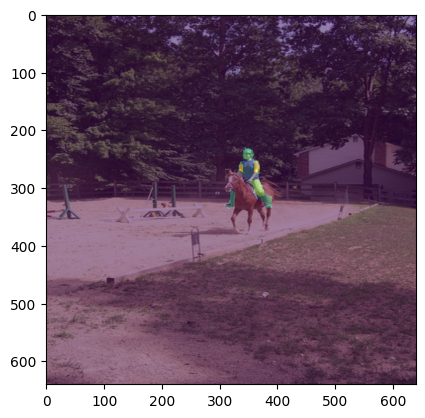

In [16]:
idx = 71
image, mask = train_dataset[idx]

transformed = transform(image=image, mask=mask)
image = transformed['image']
mask = transformed['mask']

plt.imshow(image ) # .permute(1, 2, 0).cpu().numpy())
plt.imshow(mask, alpha=0.5) # .permute(1, 2, 0).cpu().numpy(), alpha=0.5)
# plt.axis('off')
plt.show()

In [24]:
# res = model_pose.predict(
#     # image,
#     batch,
#     # iou=0.999,
#     conf=0.001, 
#     imgsz=256,
#     # device='cpu'
# ) 

In [17]:
points = []
labels = []
for r in res:
    tmp = r.keypoints.xy.reshape((-1, 2)).cpu().tolist()
    points.extend(tmp)
    labels.extend(np.arange(len(tmp)).tolist())

print(len(labels), len(points))
print(points)
print(labels)

bboxes = []
for r in res:
    bboxes.extend(r.boxes.xywh.reshape((-1, 4)).cpu().tolist())

print(len(bboxes))
print(bboxes)

2040 2040
[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [76.16067504882812, 195.6197052001953], [79.96680450439453, 195.77703857421875], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [72.1795425415039, 210.8064422607422], [75.50660705566406, 210.80706787109375], [70.37033081054688, 224.44851684570312], [78.99371337890625, 224.32777404785156], [66.06307983398438, 236.70606994628906], [80.16571044921875, 236.8300018310547], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [66.53658294677734, 201.60484313964844], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], 

In [18]:
print(np.array(points).shape, np.array(labels).shape, np.array(bboxes).shape)

(2040, 2) (2040,) (120, 4)


In [19]:
# points = [ r.keypoints.xy.cpu().tolist() for r in res]
# print(points
#         # + [[0., 0.]]
#         )
# print(len(points))

# bboxes = [r.boxes.xywh.cpu().tolist() for r in res]  # res[0].boxes.data.cpu().tolist()
# print(bboxes 
#         # + [[0., 0., 0., 0., 0., 0.]]
#         )
# print(len(bboxes))

# # print(list(range(len(points))) + [100])

# labels = [list(range(len(p))) for p in points]
# print(labels)

In [20]:
# points = res[0].keypoints.xy.cpu().tolist()
# print(points[0] + [[0., 0.]])

# bboxes = res[0].boxes.data.cpu().tolist()
# print(bboxes + [[0., 0., 0., 0., 0., 0.]])
# print(list(range(len(points[0]))) + [100])

In [21]:
res[0].boxes.xywh

tensor([[ 72.0000, 214.5000,  22.0000,  55.0000],
        [  8.5000, 203.5000,  17.0000, 249.0000],
        [ 41.5000, 190.0000,  83.0000, 284.0000],
        [  8.5000, 252.5000,  17.0000, 155.0000],
        [ 20.0000, 172.0000,  40.0000, 316.0000],
        [ 15.5000, 199.0000,  31.0000, 260.0000]], device='cuda:0')

**проблема**
 - SAM работает очень долго 

 - Нужно использовать только pose estimation keypoints

# SAM

In [22]:
# # Load a model
# model = SAM("sam_b.pt")

# Create a FastSAM model
model_sam = FastSAM("FastSAM-s.pt") 

In [23]:
# res_seg = model_sam.predict(
#     image,
#     # device='gpu',
#     iou=0.99,
#     # max_det=5,
#     # imgsz=640,
#     # imgsz=(640, 640),
#     # imgsz=image.size[:2],
#     points=points[0] + [[0., 0.]], 
#     labels=list(range(len(points[0]))) + [100], 
#     bboxes=bboxes + [[0., 0., 0., 0., 0., 0.]],
#     # conf=0.01,
#     texts= 'humans. for each human. upper body. lower body. low hand, up hand, torso, head, low leg, up leg'
#         # 'humans. body parts. specific mask for each part: upper body, lower body, head, torso, up hand, low hand, up leg, low leg'
#         # parts labels:(0) background, (1) low_hand, (6) up_hand, (2) torso, (4) head, (3) low_leg, (5) up_leg'
# )

In [24]:
batch[0].dtype

dtype('uint8')

In [25]:
res_seg = model_sam.predict(
    batch,
    # device='gpu',
    iou=0.99,
    # max_det=5,
    imgsz=256,
    # imgsz=(640, 640),
    # imgsz=image.size[:2],
    points=points, 
    labels=labels, 
    bboxes=bboxes,
    # conf=0.01,
    # texts= 'humans. for each human. upper body. lower body. low hand, up hand, torso, head, low leg, up leg'
        # 'humans. body parts. specific mask for each part: upper body, lower body, head, torso, up hand, low hand, up leg, low leg'
        # parts labels:(0) background, (1) low_hand, (6) up_hand, (2) torso, (4) head, (3) low_leg, (5) up_leg'
)


0: 192x256 24 objects, 3.1ms
1: 192x256 24 objects, 3.1ms
2: 192x256 24 objects, 3.1ms
3: 192x256 24 objects, 3.1ms
4: 192x256 24 objects, 3.1ms
5: 192x256 24 objects, 3.1ms
6: 192x256 24 objects, 3.1ms
7: 192x256 24 objects, 3.1ms
8: 192x256 24 objects, 3.1ms
9: 192x256 24 objects, 3.1ms
10: 192x256 24 objects, 3.1ms
11: 192x256 24 objects, 3.1ms
12: 192x256 24 objects, 3.1ms
13: 192x256 24 objects, 3.1ms
14: 192x256 24 objects, 3.1ms
15: 192x256 24 objects, 3.1ms
16: 192x256 24 objects, 3.1ms
17: 192x256 24 objects, 3.1ms
18: 192x256 24 objects, 3.1ms
19: 192x256 24 objects, 3.1ms
Speed: 0.3ms preprocess, 3.1ms inference, 264.5ms postprocess per image at shape (1, 3, 192, 256)


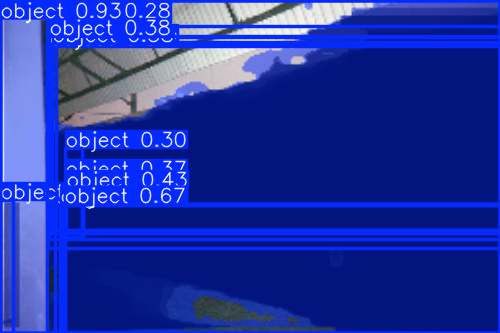

In [26]:
res_seg[0].show()

In [36]:
res_seg[3].masks.data.shape

torch.Size([24, 192, 256])

In [48]:
final_mask = [torch.sum(r.masks.data.cpu(), dim=0).numpy() for r in res_seg]
# final_mask = torch.tensor(final_mask).unsqueeze(1)
final_mask = np.array(final_mask)
print(final_mask.shape)
print(final_mask)

(20, 192, 256)
[[[          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  ...
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]]

 [[          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  ...
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]]

 [[      

In [15]:
torch.tensor(final_mask)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

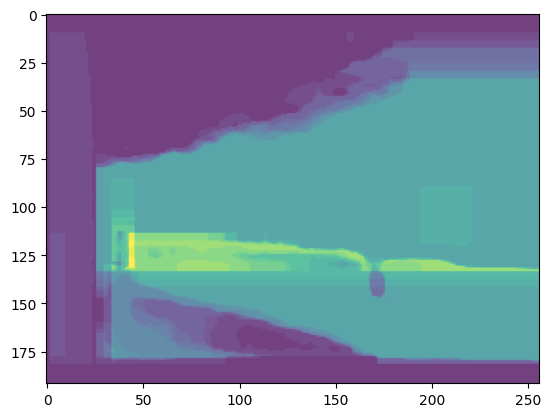

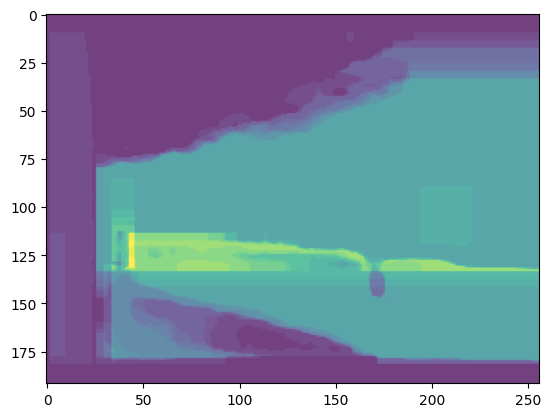

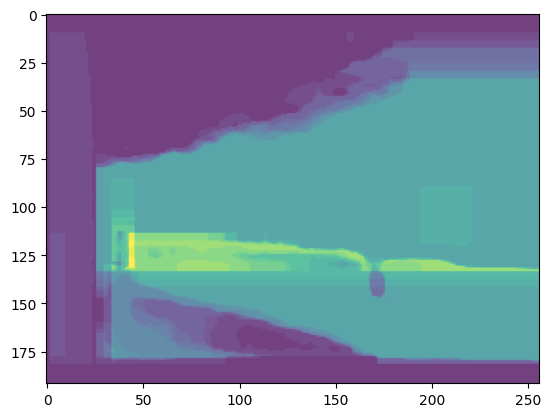

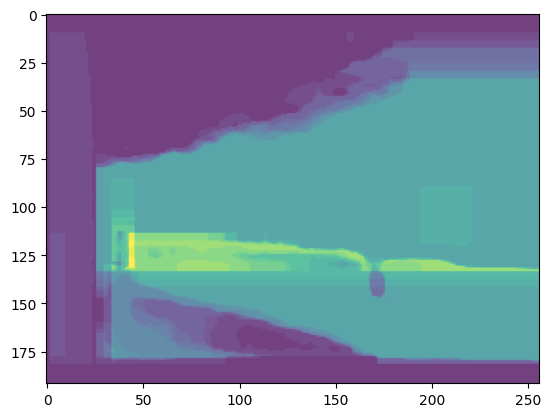

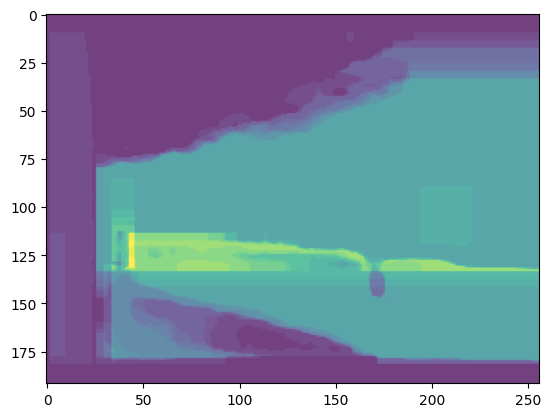

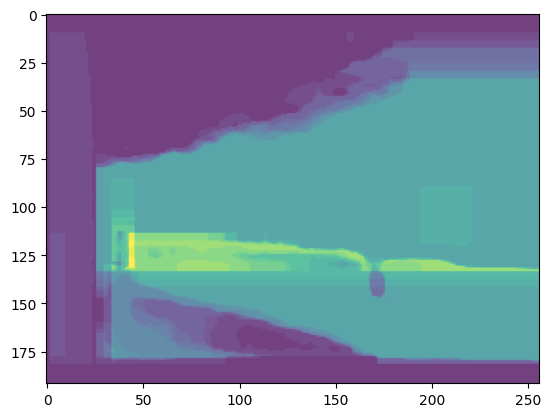

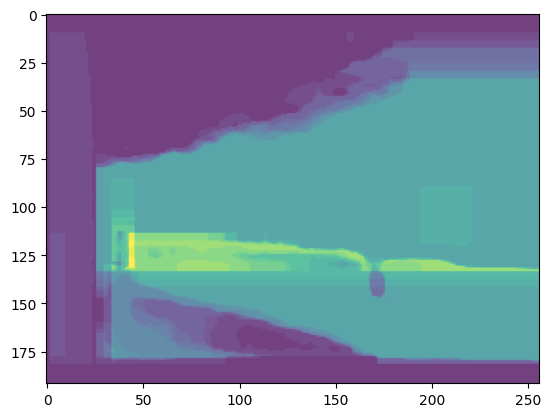

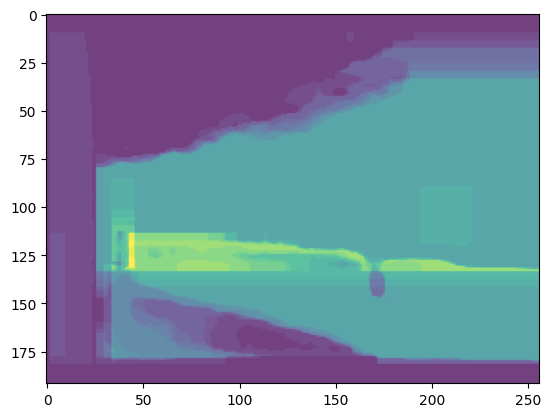

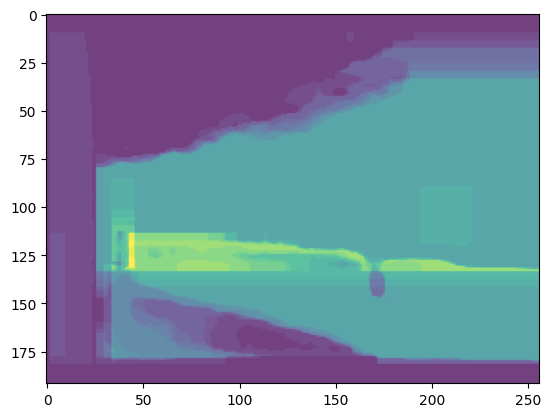

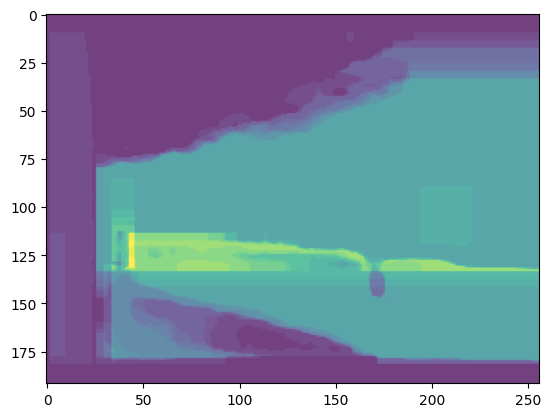

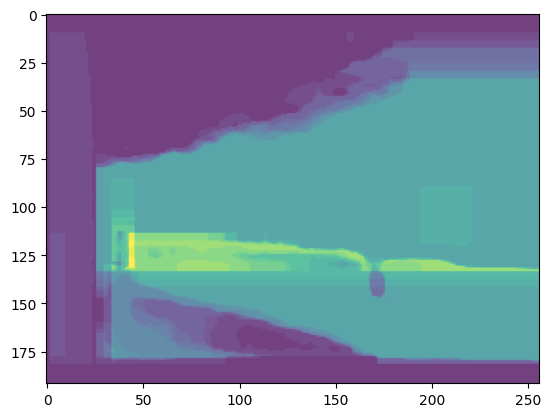

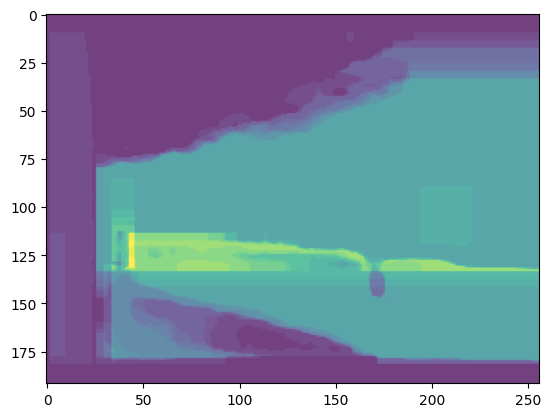

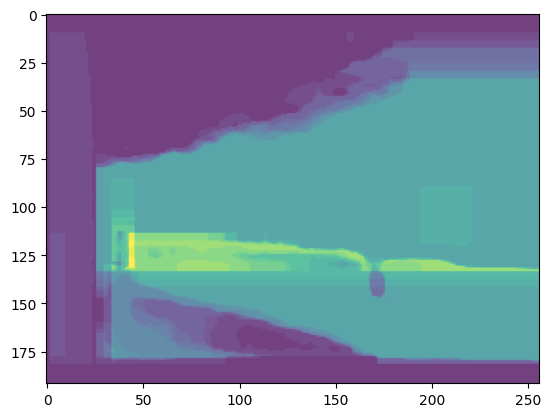

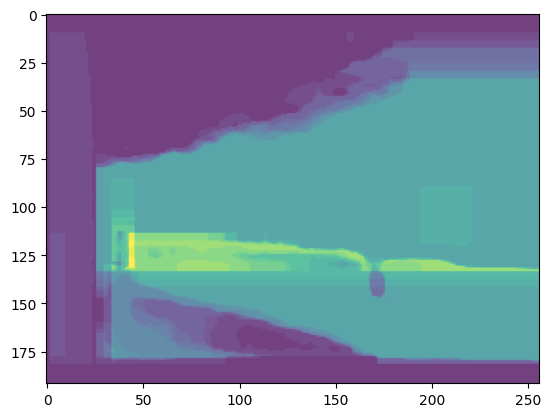

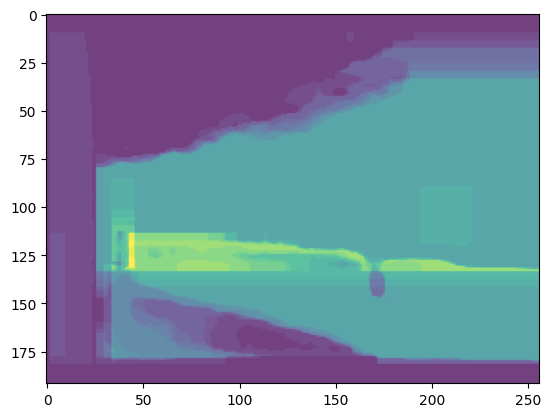

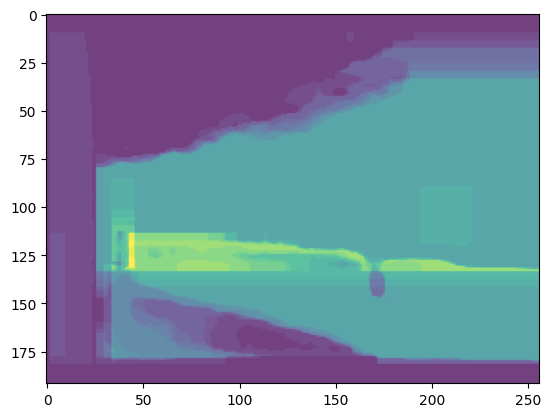

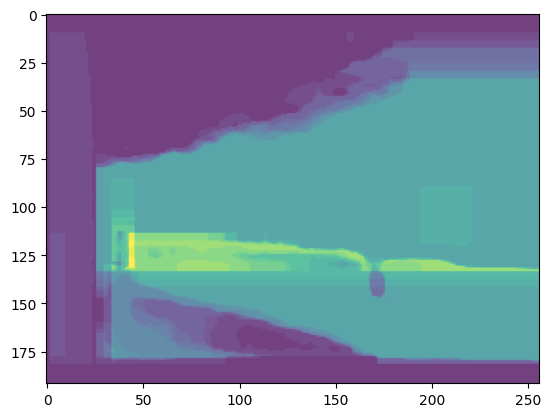

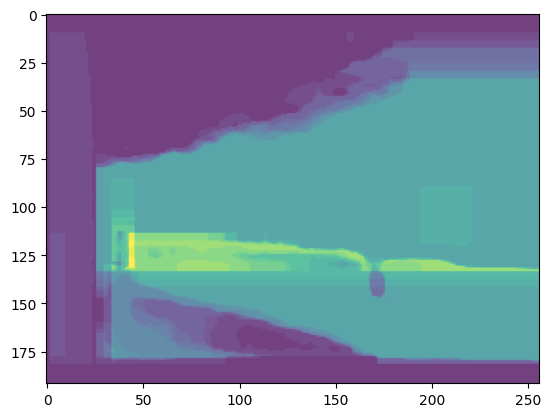

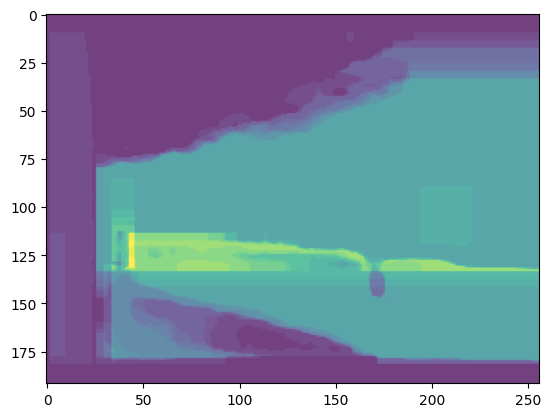

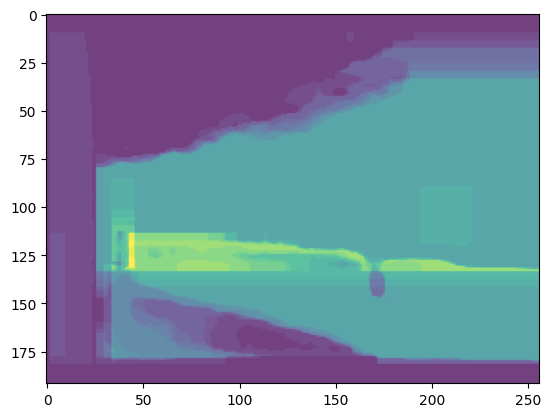

In [50]:
# final_mask = torch.sum(res_seg[0].masks.data.cpu(), dim=0)

# plt.imshow(res_seg[0].orig_img)
# plt.imshow(final_mask , alpha=0.75)
# plt.show()

for i in range(len(batch)):
    final_mask = torch.sum(res_seg[i].masks.data.cpu(), dim=0)

    # plt.imshow(res_seg[i].orig_img)
    plt.imshow(final_mask , alpha=0.75)
    plt.show()

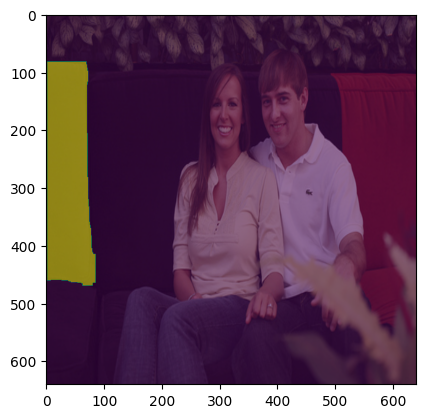

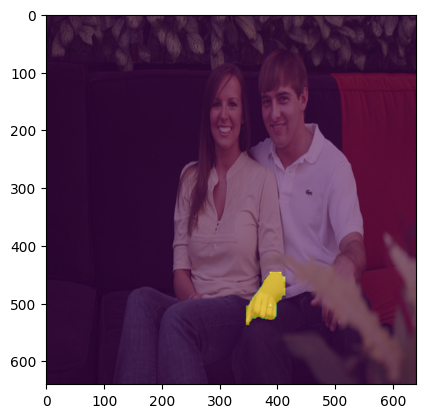

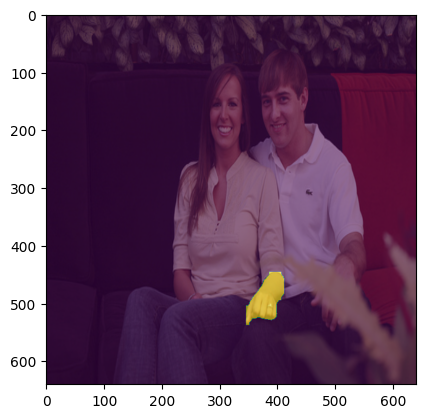

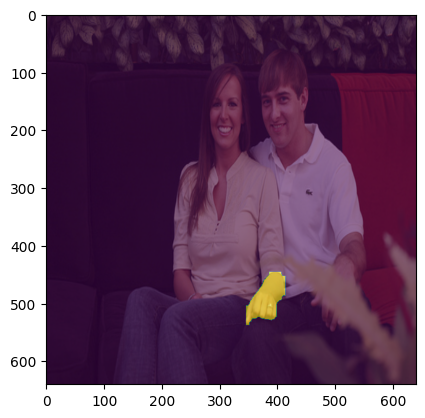

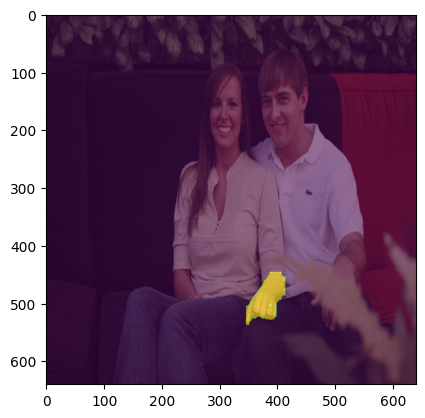

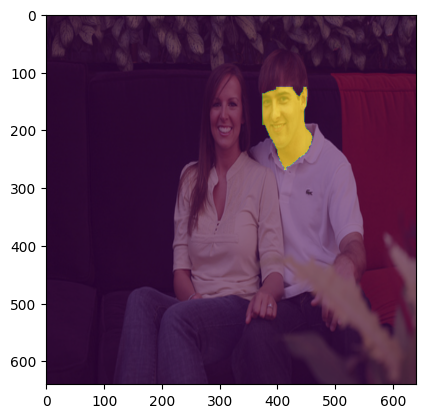

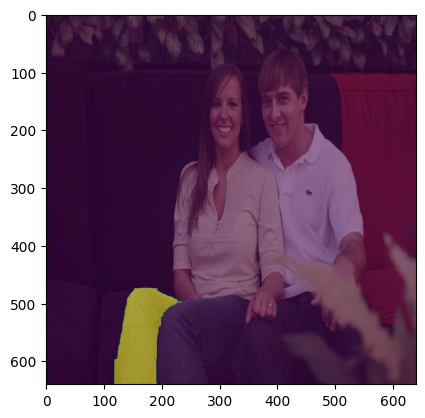

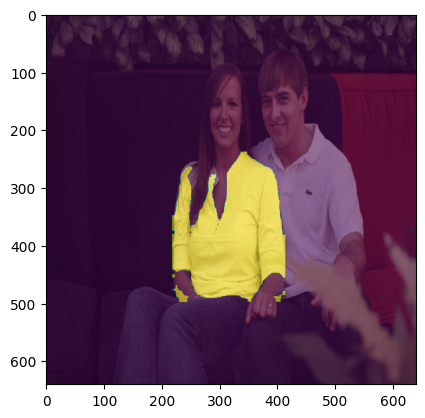

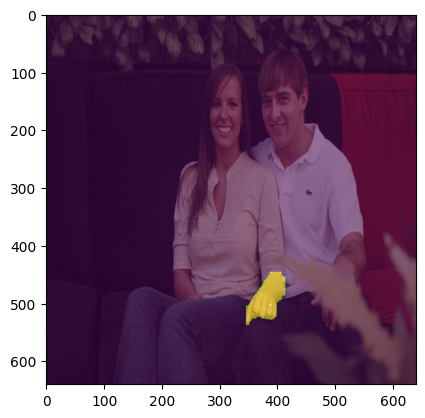

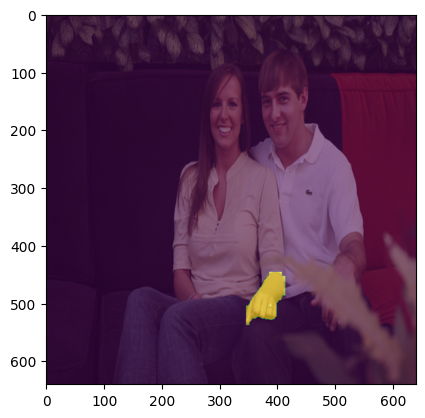

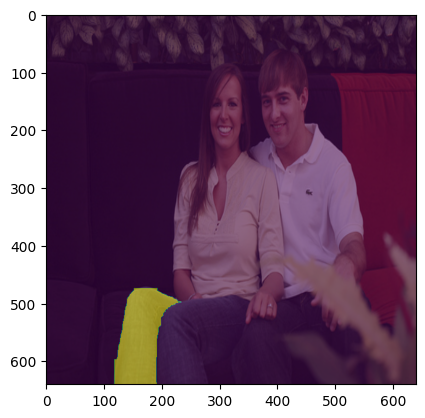

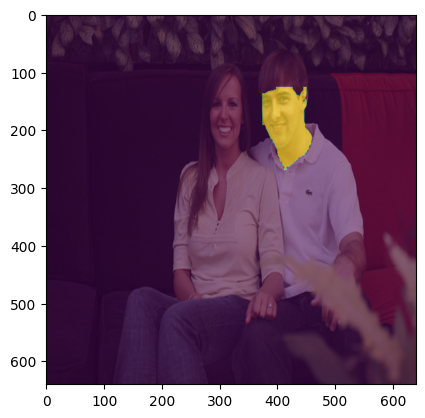

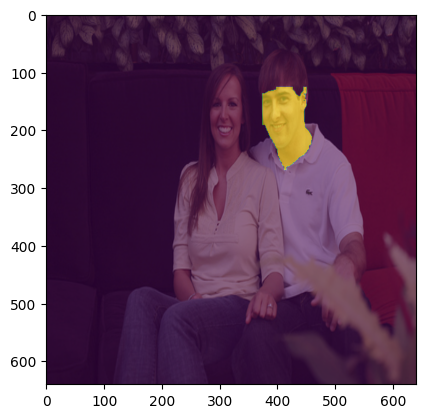

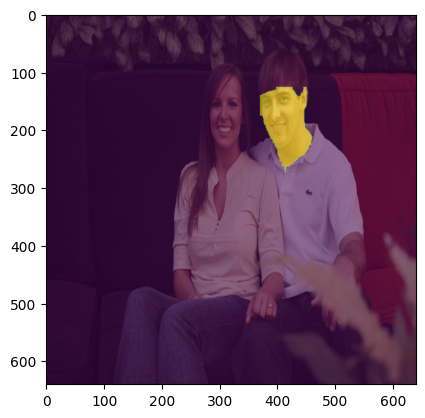

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [37]:
for i in range(len(res_seg[0].masks)):
    plt.imshow(res_seg[0].orig_img)
    plt.imshow(res_seg[0].masks.data.cpu().numpy()[i], alpha=0.55)
    plt.show()